In [1]:
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from tqdm import tqdm
from pathlib import Path
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor,ExtraTreesRegressor
from scipy.optimize import curve_fit
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import r2_score, mean_squared_error
from statsmodels.graphics.gofplots import qqplot
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.outliers_influence import OLSInfluence as influence
from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression,BayesianRidge,LinearRegression
from sklearn.ensemble import BaggingRegressor
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.inspection import permutation_importance
from sklearn.model_selection import GridSearchCV

# Gather datasets

In [2]:
data = pd.read_pickle('E:\\fitness-prediction\\saved-metrics.pkl')


In [3]:
data = data.fillna(0)

In [4]:
metric2 = data[data.type==2].fillna(0)

metric_list = list(metric2.columns.drop('total biomass'))


# Plot all possible metrics vs biomass

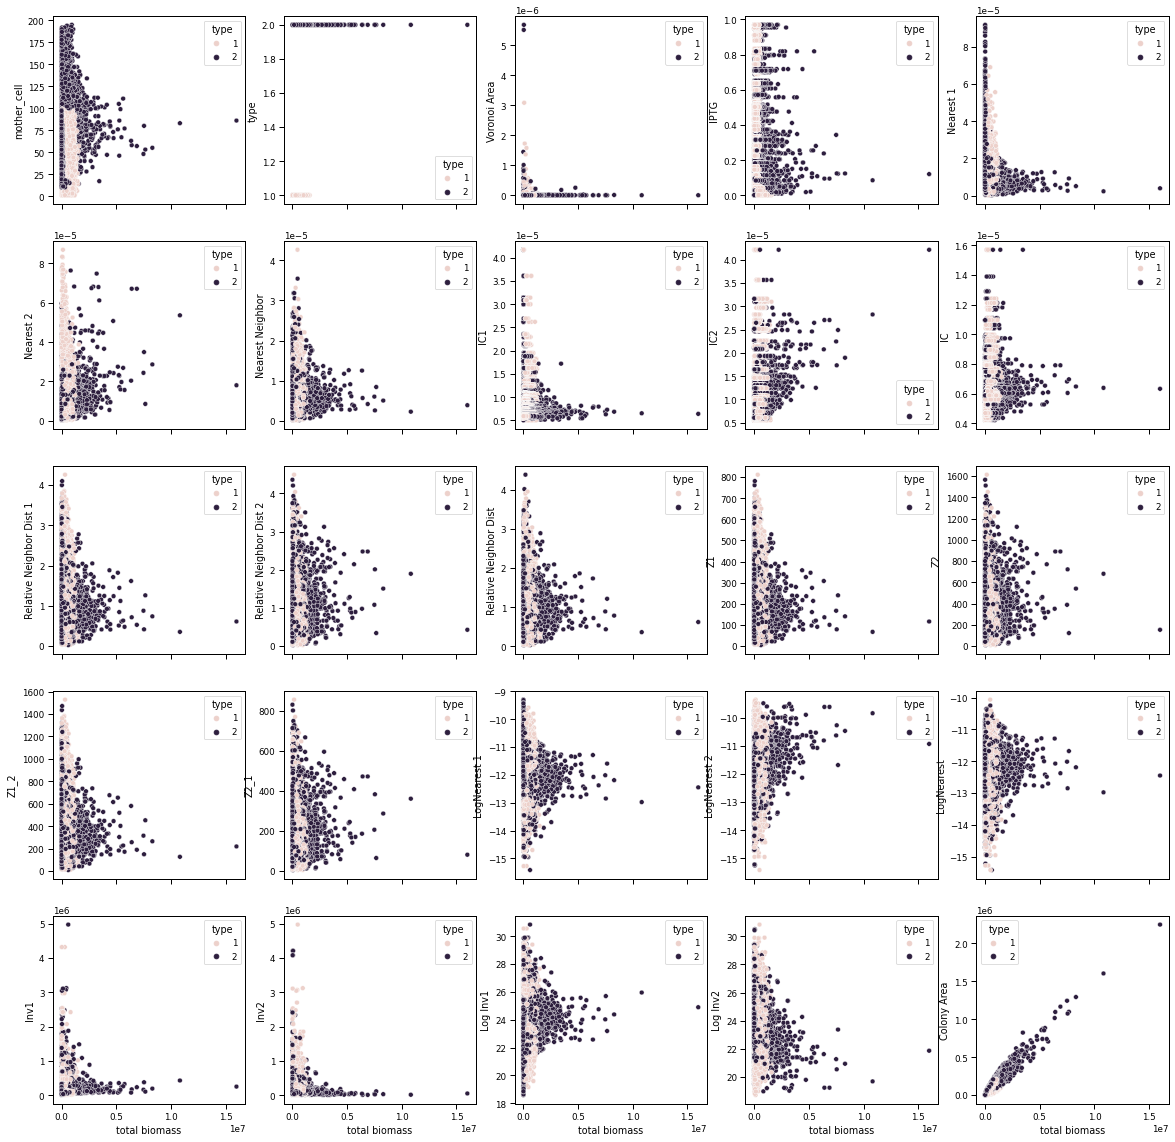

In [7]:
sns.set_context('paper')
f, axes = plt.subplots(nrows = int(np.sqrt(len(metric_list))),ncols=int(np.sqrt(len(metric_list))),figsize=(20,20),sharex=True)
for met,ax in zip(metric_list,axes.ravel()):
   sns.scatterplot(x='total biomass',y=met,hue='type',data=data,ax=ax)
plt.show()
for ax in axes.ravel():
   ax.set_xscale('log')
   ax.set_yscale('log')


In [5]:
predictors = list(data.columns.drop(['total biomass','Colony Area','mother_cell']))#,'Relative Neighbor Dist','Relative Neighbor Dist 1','Relative Neighbor Dist 2',
#'Z1_2','Z2_1','LogNearest','LogNearest 1','LogNearest 2','Log Inv1','Log Inv2','Nearest 1','Nearest 2',]))
data2 = data[data.type==2]
X = data2[predictors]
y = data2['total biomass']
#X = sm.add_constant(X)

# Split data into fitting and testing groups

In [6]:
train_X, test_X, train_y, test_y = train_test_split(X, y, train_size = 0.8, random_state = 42)

# Preliminary model fitting

In [7]:
model = sm.OLS(train_y, train_X)
model = model.fit()
print(model.summary2())

                                        Results: Ordinary least squares
Model:                             OLS                            Adj. R-squared:                   0.322      
Dependent Variable:                total biomass                  AIC:                              606330.1111
Date:                              2022-01-03 11:52               BIC:                              606465.8094
No. Observations:                  21639                          Log-Likelihood:                   -3.0315e+05
Df Model:                          16                             F-statistic:                      643.2      
Df Residuals:                      21622                          Prob (F-statistic):               0.00       
R-squared:                         0.322                          Scale:                            8.6342e+10 
---------------------------------------------------------------------------------------------------------------
                               C

# Define backward regression algorithm

In [8]:
def backward_regression(X, y,
                           threshold_out,
                           verbose=False):
    included=list(X.columns)
    while True:
        changed=False
        model = sm.OLS(y,X[included]).fit()
        pvalues = model.pvalues
        worst_pval = pvalues.max()
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.idxmax()
            included.remove(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
        if not changed:
            break
    return included,model
threshold = 0.0001

# Perform backward regression to find the best fitting parameters

In [9]:
#stats = list(data.columns.drop(['total biomass','Colony Area']))
reg_mets,model = backward_regression(train_X, train_y, threshold_out=threshold,
                           verbose=True)
reg_mets

Drop Relative Neighbor Dist 2       with p-value 0.848778
Drop Z1                             with p-value 0.78191
Drop Z2_1                           with p-value 0.926015
Drop Voronoi Area                   with p-value 0.768946
Drop LogNearest                     with p-value 0.487296
Drop Inv1                           with p-value 0.451774
Drop Inv2                           with p-value 0.459366
Drop Log Inv2                       with p-value 0.00478628
Drop Relative Neighbor Dist 1       with p-value 0.0567039
Drop LogNearest 2                   with p-value 0.00477951
Drop Nearest 1                      with p-value 0.000542408
Drop IC1                            with p-value 0.00387692


['type',
 'IPTG',
 'Nearest 2',
 'Nearest Neighbor',
 'IC2',
 'IC',
 'Relative Neighbor Dist',
 'Z2',
 'Z1_2',
 'LogNearest 1',
 'Log Inv1']

# Check the resulting fit

In [10]:
predictions = model.predict(test_X[reg_mets])
df_results = pd.DataFrame({'Actual' : test_y, 'Predicted': predictions})

print(model.summary())


                            OLS Regression Results                            
Dep. Variable:          total biomass   R-squared:                       0.322
Model:                            OLS   Adj. R-squared:                  0.321
Method:                 Least Squares   F-statistic:                     1139.
Date:                Mon, 03 Jan 2022   Prob (F-statistic):               0.00
Time:                        11:53:10   Log-Likelihood:            -3.0316e+05
No. Observations:               21639   AIC:                         6.063e+05
Df Residuals:                   21629   BIC:                         6.064e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
type                    3.04

In [11]:

RMSE = np.sqrt(mean_squared_error(test_y, predictions))
r2 = r2_score(test_y, predictions)
print(RMSE, r2)

334052.9514729762 0.26271341188579855


# Evaluate resulting model

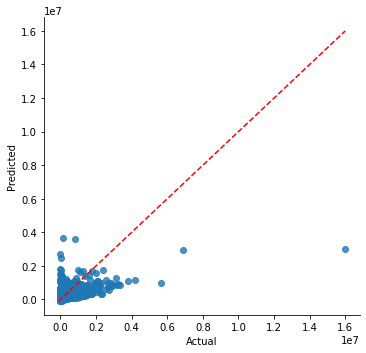

In [12]:
#Plot the actual vs predicted results
sns.lmplot(x='Actual', y='Predicted', data=df_results, fit_reg=False)
#Plot the diagonal line
d_line= np.arange(df_results.min().min(), df_results.max().max())
plt.plot(d_line, d_line, color='red', linestyle='--')
plt.show()

# Check that the residuals are normally distributed

C:\Users\Jonathan\anaconda3\envs\nufeb\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


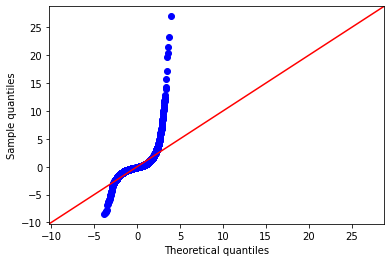

In [13]:

fig=qqplot(model.resid_pearson,line='45',fit='True')
plt.xlabel('Theoretical quantiles')
plt.ylabel('Sample quantiles')
plt.show()

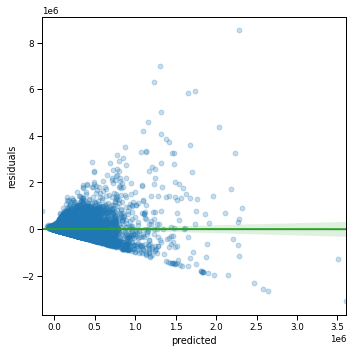

In [17]:
fig, ax = plt.subplots(figsize=(5, 5))
sns.regplot(model.fittedvalues,model.resid, scatter_kws={'alpha': 0.25}, line_kws={'color': 'C2', 'lw': 2}, ax=ax)
ax.set_xlabel('predicted')
ax.set_ylabel('residuals')
plt.tight_layout()
plt.show()

# Durbin-Watson test for autocorrelation

In [18]:

durbinWatson = durbin_watson(model.resid)
print(durbinWatson)

1.987549594767378


<AxesSubplot:>

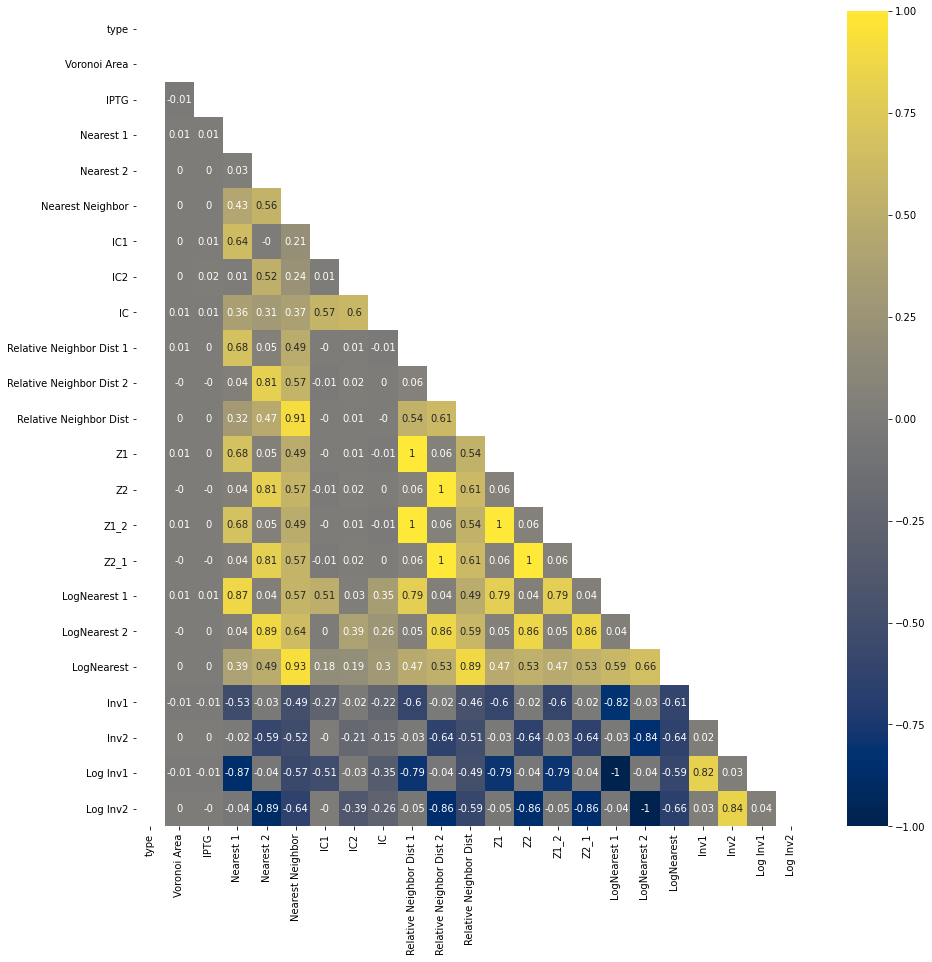

In [14]:
f, ax = plt.subplots(figsize=(15,15))
mask = np.zeros_like(train_X.corr())
mask[np.triu_indices_from(mask)] = True
sns.heatmap(train_X.corr().round(2), annot=True, mask=mask, cmap="cividis",ax=ax)

# Outlier detection using Cook’s distance plot

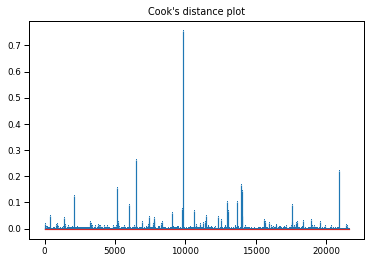

In [20]:

f, ax = plt.subplots()
inf=influence(model)
(i, d) = inf.cooks_distance
ax.set_title("Cook's distance plot")
ax.stem(np.arange(len(i)), i, markerfmt=",")
plt.show()

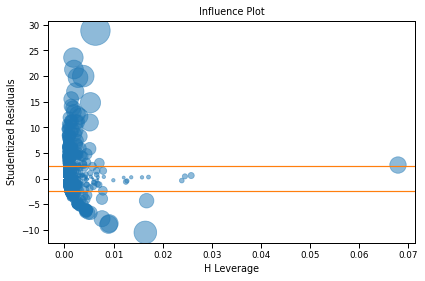

In [21]:
from statsmodels.stats.outliers_influence import OLSInfluence 
influence = OLSInfluence(model)
fig, ax = plt.subplots()
ax.axhline(-2.5, linestyle='-', color='C1')
ax.axhline(2.5, linestyle='-', color='C1')
ax.scatter(influence.hat_matrix_diag, influence.resid_studentized_internal, 
 s=1000 * np.sqrt(influence.cooks_distance[0]),
 alpha=0.5)
ax.set_xlabel('H Leverage')
ax.set_ylabel('Studentized Residuals')
ax.set_title('Influence Plot')
plt.tight_layout()
plt.show()

In [22]:
""" f, ax = plt.subplots()

ax.scatter(predictions,y)
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

# now plot both limits against eachother
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)
ax.set_xlabel('Prediction')
ax.set_ylabel('Total biomass')
plt.show() """

" f, ax = plt.subplots()\n\nax.scatter(predictions,y)\nlims = [\n    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes\n    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes\n]\n\n# now plot both limits against eachother\nax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)\nax.set_aspect('equal')\nax.set_xlim(lims)\nax.set_ylim(lims)\nax.set_xlabel('Prediction')\nax.set_ylabel('Total biomass')\nplt.show() "

# Regression with scaled metrics

In [23]:
#RECURSIVE FEATURE ELIMINATION
#Feature ranking with recursive feature elimination and cross-validated selection of the best number of features

names=pd.DataFrame(train_X.columns)

#use linear regression as the model
lin_reg = LinearRegression()

#This is to select 5 variables: can be changed and checked in model for accuracy
rfe_mod = RFE(lin_reg, 3, step=1) #RFECV(lin_reg, step=1, cv=5) 
myvalues=rfe_mod.fit(X,y) #to fit
myvalues.support_#The mask of selected features.
myvalues.ranking_ #The feature ranking, such that ranking_[i] corresponds to the ranking position of the i-th feature. Selected (i.e., estimated best) features are assigned rank 1.

rankings=pd.DataFrame(myvalues.ranking_) #Make it into data frame
#Concat and name columns
ranked=pd.concat([names,rankings], axis=1)
ranked.columns = ["Feature", "Rank"]
ranked

#Select most important (Only 1's)
most_important = ranked.loc[ranked['Rank'] ==1] 
print(most_important)

most_important['Rank'].count()

        Feature  Rank
1  Voronoi Area     1
5           IC2     1
6            IC     1


3

In [24]:

model = sm.OLS(train_y,train_X[most_important['Feature']]).fit()
predictions = model.predict(test_X[most_important['Feature']])
df_results = pd.DataFrame({'Actual' : test_y, 'Predicted': predictions})

print(model.summary())

                                 OLS Regression Results                                
Dep. Variable:          total biomass   R-squared (uncentered):                   0.434
Model:                            OLS   Adj. R-squared (uncentered):              0.434
Method:                 Least Squares   F-statistic:                              5532.
Date:                Thu, 23 Dec 2021   Prob (F-statistic):                        0.00
Time:                        16:22:55   Log-Likelihood:                     -3.0398e+05
No. Observations:               21639   AIC:                                  6.080e+05
Df Residuals:                   21636   BIC:                                  6.080e+05
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                   coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------

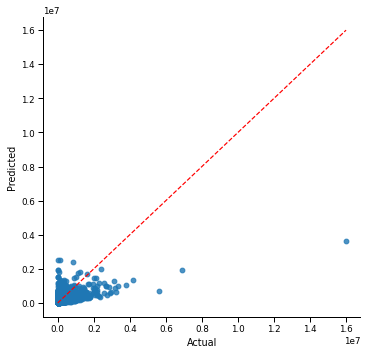

In [25]:
#Plot the actual vs predicted results
sns.lmplot(x='Actual', y='Predicted', data=df_results, fit_reg=False)
#Plot the diagonal line
d_line= np.arange(df_results.min().min(), df_results.max().max())
plt.plot(d_line, d_line, color='red', linestyle='--')
plt.show()

In [31]:
""" predictors = list(data.columns.drop(['total biomass','Colony Area','mother_cell','type'])) #'Relative Neighbor Dist','Relative Neighbor Dist 1','Relative Neighbor Dist 2',
'Z1_2','Z2_1','LogNearest','LogNearest 1','LogNearest 2','Log Inv1','Log Inv2','Nearest 1','Nearest 2', """
predictors = list(data.columns.drop(['total biomass','Colony Area','mother_cell'])) 
data2 = data[data.type==2]
X = data2[predictors]
y = data2['total biomass']
train_X, test_X, train_y, test_y = train_test_split(X, y, train_size = 0.9, random_state = 42)

In [32]:
model_rf = RandomForestRegressor(n_estimators=1000, oob_score=True, random_state=100,n_jobs=-1)

model_rf.fit(train_X, train_y) 

pred_train_rf= model_rf.predict(train_X)

print(np.sqrt(mean_squared_error(train_y,pred_train_rf)))
print(r2_score(train_y, pred_train_rf))



pred_test_rf = model_rf.predict(test_X)

print(np.sqrt(mean_squared_error(test_y,pred_test_rf)))

print(r2_score(test_y, pred_test_rf))



107084.89905288641
0.9146738813064309
235641.19277026507
0.5035322351213135


In [15]:
model_et = ExtraTreesRegressor(n_estimators=1000, random_state=100,n_jobs=-1)
model_et.fit(train_X, train_y) 

pred_train_et= model_et.predict(train_X)
pred_test_et = model_et.predict(test_X)
print(np.sqrt(mean_squared_error(train_y,pred_train_et)))
print(r2_score(train_y, pred_train_et))
print(np.sqrt(mean_squared_error(test_y,pred_test_et)))

print(r2_score(test_y, pred_test_et))
score = model_et.score(train_X, train_y)
print("Score: ", score)
cv_scores = cross_val_score(model_et, train_X,train_y,cv=10)
print("Mean cross-validataion score: %.2f" % cv_scores.mean())

5.3102518679834286e-09
1.0
341227.2984317792
0.23070441007465348
Score:  1.0
Mean cross-validataion score: 0.39


>10 0.201 (0.238)
>50 0.238 (0.241)
>100 0.244 (0.246)
>500 0.251 (0.248)


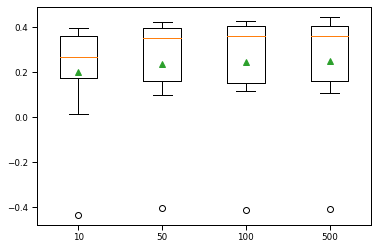

In [34]:
# get a list of models to evaluate
def get_models():
	models = dict()
	# define number of trees to consider
	n_trees = [10, 50, 100, 500]
	for n in n_trees:
		models[str(n)] = ExtraTreesRegressor(n_estimators=n, random_state=100,n_jobs=-1)
	return models
# evaluate a given model using cross-validation
def evaluate_model(model, X, y):
	# define the evaluation procedure
	fit = model.fit(X, y) 
	# evaluate the model and collect the results
	#cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
	scores = cross_val_score(model, X, y, cv=10, n_jobs=-1)
	return scores
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
	# evaluate the model
	scores = evaluate_model(model, train_X, train_y)
	# store the results
	results.append(scores)
	names.append(name)
	# summarize the performance along the way
	print('>%s %.3f (%.3f)' % (name, np.mean(scores), np.std(scores)))
# plot model performance for comparison
plt.boxplot(results, labels=names, showmeans=True)
plt.show()

>1 0.264 (0.175)
>2 0.283 (0.218)
>3 0.277 (0.231)
>4 0.299 (0.225)
>5 0.303 (0.228)
>6 0.304 (0.234)
>7 0.295 (0.239)
>8 0.281 (0.238)
>9 0.294 (0.222)
>10 0.286 (0.239)
>11 0.279 (0.236)
>12 0.280 (0.241)
>13 0.281 (0.243)
>14 0.263 (0.238)
>15 0.269 (0.242)
>16 0.257 (0.238)
>17 0.258 (0.236)
>18 0.253 (0.238)
>19 0.259 (0.239)
>20 0.255 (0.241)
>21 0.253 (0.246)
>22 0.256 (0.248)


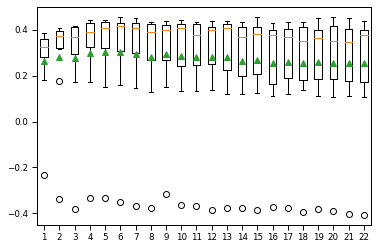

In [35]:
def get_models():
	models = dict()
	# explore number of features from 1 to 20
	for i in range(1, 23):
		models[str(i)] = ExtraTreesRegressor(max_features=i)
	return models
 
# evaluate a given model using cross-validation
 
# define dataset

# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
	# evaluate the model
	scores = evaluate_model(model, train_X, train_y)
	# store the results
	results.append(scores)
	names.append(name)
	# summarize the performance along the way
	print('>%s %.3f (%.3f)' % (name, np.mean(scores), np.std(scores)))
# plot model performance for comparison
plt.boxplot(results, labels=names, showmeans=True)
plt.show()

In [36]:
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
print(cv)

RepeatedStratifiedKFold(n_repeats=3, n_splits=10, random_state=1)


NameError: name 'pred_train_rf' is not defined

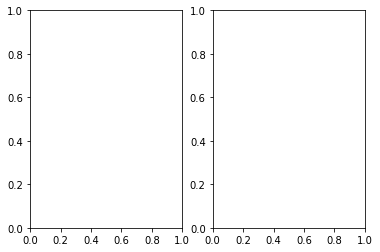

In [19]:
f, axes = plt.subplots(ncols=2)
axes[0].scatter(train_y,pred_train_rf)
axes[1].scatter(test_y,pred_test_rf)
#Plot the diagonal line
d_line= np.arange(train_y.min(), train_y.max())
axes[0].plot(d_line, d_line, color='red', linestyle='--')
d_line= np.arange(test_y.min(), test_y.max())
axes[1].plot(d_line, d_line, color='red', linestyle='--')
axes[0].set_title('Train fit')
axes[1].set_title('Test fit')
plt.show()

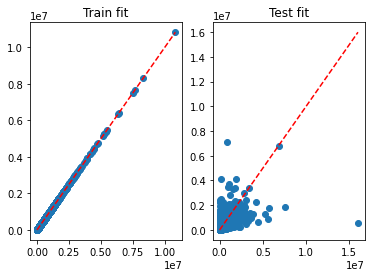

In [18]:
f, axes = plt.subplots(ncols=2)
axes[0].scatter(train_y,pred_train_et)
axes[1].scatter(test_y,pred_test_et)
#Plot the diagonal line
d_line= np.arange(train_y.min(), train_y.max())
axes[0].plot(d_line, d_line, color='red', linestyle='--')
d_line= np.arange(test_y.min(), test_y.max())
axes[1].plot(d_line, d_line, color='red', linestyle='--')
axes[0].set_title('Train fit')
axes[1].set_title('Test fit')
plt.show()

Score:  1.0
Mean cross-validataion score: 0.22


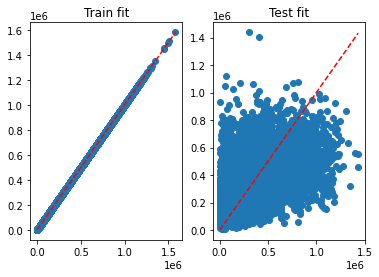

           0         1                         2
2   1.057113  0.011268                      IPTG
6   0.445058   0.00359                       IC1
8   0.154688  0.001481                        IC
13  0.052745  0.000485                        Z2
10  0.050198  0.000434  Relative Neighbor Dist 2
15  0.049675  0.000444                      Z2_1
7   0.042436  0.000471                       IC2
21  0.038047  0.000289                  Log Inv1
16  0.036754  0.000188              LogNearest 1
3   0.033709  0.000298                 Nearest 1
12  0.033562  0.000285                        Z1
14  0.033222  0.000328                      Z1_2
9   0.032825  0.000274  Relative Neighbor Dist 1
11  0.032215  0.000259    Relative Neighbor Dist
4   0.031224  0.000231                 Nearest 2
19  0.029929  0.000157                      Inv1
22  0.027337  0.000148                  Log Inv2
17  0.025616  0.000096              LogNearest 2
5   0.024549  0.000146          Nearest Neighbor
18  0.022156  0.0001

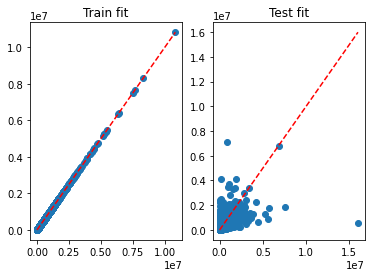

           0         1                         2
7   0.919437  0.007985                       IC2
2   0.643875   0.01525                      IPTG
6   0.151501  0.003981                       IC1
4   0.054681  0.000865                 Nearest 2
8   0.053014  0.001061                        IC
22  0.031678  0.000475                  Log Inv2
17  0.029743  0.000494              LogNearest 2
3   0.019466   0.00061                 Nearest 1
16  0.017551  0.000526              LogNearest 1
21  0.016686  0.000545                  Log Inv1
10  0.016579   0.00058  Relative Neighbor Dist 2
13  0.016255   0.00056                        Z2
15  0.016145  0.000536                      Z2_1
20  0.015893  0.000239                      Inv2
14  0.011723  0.000364                      Z1_2
11  0.011637  0.000164    Relative Neighbor Dist
9   0.011377  0.000323  Relative Neighbor Dist 1
19  0.011128  0.000606                      Inv1
12  0.011057  0.000317                        Z1
5   0.009856  0.0003

In [17]:
predictors = list(data.columns.drop(['total biomass','Colony Area','mother_cell'])) #'Relative Neighbor Dist','Relative Neighbor Dist 1','Relative Neighbor Dist 2',
#'Z1_2','Z2_1','LogNearest','LogNearest 1','LogNearest 2','Log Inv1','Log Inv2','Nearest 1','Nearest 2',
for i in [1,2]:
    data2 = data[data.type==i]
    X = data2[predictors]
    y = data2['total biomass']
    train_X, test_X, train_y, test_y = train_test_split(X, y, train_size = 0.7, random_state = 42)

    #model_et = ExtraTreesRegressor(n_estimators=500, random_state=100,max_features=6,max_depth=50,bootstrap=True,n_jobs=-1)
    model_et = ExtraTreesRegressor(n_estimators=500, random_state=100,n_jobs=-1)
    model_et.fit(train_X, train_y) 

    pred_train_et= model_et.predict(train_X)
    pred_test_et = model_et.predict(test_X)

    score = model_et.score(train_X, train_y)
    print("Score: ", score)
    cv_scores = cross_val_score(model_et, train_X,train_y,cv=3)
    print("Mean cross-validataion score: %.2f" % cv_scores.mean())
    f, axes = plt.subplots(ncols=2)
    axes[0].scatter(train_y,pred_train_et)
    axes[1].scatter(test_y,pred_test_et)
    #Plot the diagonal line
    d_line= np.arange(train_y.min(), train_y.max())
    axes[0].plot(d_line, d_line, color='red', linestyle='--')
    d_line= np.arange(test_y.min(), test_y.max())
    axes[1].plot(d_line, d_line, color='red', linestyle='--')
    axes[0].set_title('Train fit')
    axes[1].set_title('Test fit')
    plt.show()
    #feats = pd.DataFrame([model_et.feature_importances_,X.columns]).T
    #print(feats.sort_values(by=0,ascending=False))
    
    result = permutation_importance(model_et, train_X, train_y, random_state=0)
    feats = pd.DataFrame([result.importances_mean,result.importances_std,X.columns]).T
    print(feats.sort_values(by=0,ascending=False))

Score:  0.8855955402845832
Mean cross-validataion score: 0.38


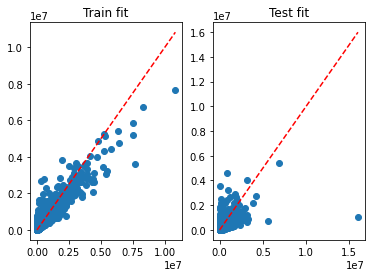

In [16]:

bag_regressor = BaggingRegressor(random_state=1,n_jobs=-1)
bag_regressor.fit(train_X, train_y) 


pred_train_bag =bag_regressor.predict(train_X)
pred_test_bag = bag_regressor.predict(test_X)

score = bag_regressor.score(train_X, train_y)
print("Score: ", score)
cv_scores = cross_val_score(bag_regressor, train_X,train_y,cv=10)
print("Mean cross-validataion score: %.2f" % cv_scores.mean())
f, axes = plt.subplots(ncols=2)
axes[0].scatter(train_y,pred_train_bag)
axes[1].scatter(test_y,pred_test_bag)
#Plot the diagonal line
d_line= np.arange(train_y.min(), train_y.max())
axes[0].plot(d_line, d_line, color='red', linestyle='--')
d_line= np.arange(test_y.min(), test_y.max())
axes[1].plot(d_line, d_line, color='red', linestyle='--')
axes[0].set_title('Train fit')
axes[1].set_title('Test fit')
plt.show()

In [7]:

n_samples = X.shape[0]
n_features = X.shape[1]

params = {'base_estimator': [None, LinearRegression(), KNeighborsRegressor()],
          'n_estimators': [20,50,100],
          'max_samples': [0.5,1.0, n_samples//2,],
          'max_features': [0.5,1.0, n_features//2,],
          'bootstrap': [True, False],
          'bootstrap_features': [True, False]}

bagging_regressor_grid = GridSearchCV(BaggingRegressor(random_state=1, n_jobs=-1), param_grid =params, cv=3, n_jobs=-1, verbose=1)
bagging_regressor_grid.fit(train_X, train_y)

print('Train R^2 Score : %.3f'%bagging_regressor_grid.best_estimator_.score(train_X, train_y))
print('Test R^2 Score : %.3f'%bagging_regressor_grid.best_estimator_.score(test_X, test_y))
print('Best R^2 Score Through Grid Search : %.3f'%bagging_regressor_grid.best_score_)
print('Best Parameters : ',bagging_regressor_grid.best_params_)

Fitting 3 folds for each of 324 candidates, totalling 972 fits


KeyboardInterrupt: 

In [8]:
params = {'n_estimators': [20,50,100],
          'max_depth': [None, 2, 5],
          'min_samples_split': [2, 0.5, n_samples//2, ],
          'min_samples_leaf': [1, 0.5, n_samples//2, ],
          'criterion': ['mse', 'mae'],
          'max_features': [None, 'sqrt', 'auto', 'log2', 0.3,0.5, n_features//2,  ],
          'bootstrap':[True, False]
         }

rf_regressor_grid = GridSearchCV(RandomForestRegressor(random_state=1), param_grid=params, n_jobs=6, cv=3, verbose=1)
rf_regressor_grid.fit(train_X, train_y)

print('Train R^2 Score : %.3f'%rf_regressor_grid.best_estimator_.score(train_X, train_y))
print('Test R^2 Score : %.3f'%rf_regressor_grid.best_estimator_.score(test_X, test_y))
print('Best R^2 Score Through Grid Search : %.3f'%rf_regressor_grid.best_score_)
print('Best Parameters : ',rf_regressor_grid.best_params_)

Fitting 3 folds for each of 2268 candidates, totalling 6804 fits


In [20]:
params = {'n_estimators': [100,500],
          'max_depth': [None, 2,5,],
          'min_samples_split': [2, 0.5, n_samples//2, ],
          'min_samples_leaf': [1, 0.5, n_samples//2, ],
          'criterion': ['mse', 'mae'],
          'max_features': [None, 'sqrt', 'auto', 'log2', 0.3],
          'bootstrap':[True, False]
         }

ef_regressor_grid = GridSearchCV(ExtraTreesRegressor(random_state=1), param_grid=params, n_jobs=-1, cv=3, verbose=1)
ef_regressor_grid.fit(train_X, train_y)

print('Train R^2 Score : %.3f'%ef_regressor_grid.best_estimator_.score(train_X, train_y))
print('Test R^2 Score : %.3f'%ef_regressor_grid.best_estimator_.score(test_X, test_y))
print('Best R^2 Score Through Grid Search : %.3f'%ef_regressor_grid.best_score_)
print('Best Parameters : ',ef_regressor_grid.best_params_)

NameError: name 'n_samples' is not defined

In [ ]:
predictors = list(data.columns.drop(['total biomass','Colony Area','mother_cell',])) #'Relative Neighbor Dist','Relative Neighbor Dist 1','Relative Neighbor Dist 2',
#'Z1_2','Z2_1','LogNearest','LogNearest 1','LogNearest 2','Log Inv1','Log Inv2','Nearest 1','Nearest 2',
data2 = data[data.type==2]
X = data2[predictors]
y = data2['total biomass']
train_X, test_X, train_y, test_y = train_test_split(X, y, train_size = 0.8, random_state = 42)